# POLI/USP Trabalho de Conclusão de Curso
## Análises de Convergência e Índice de Coleman-Liau
Autor: Gabriel Benvegmi

Esse notebook faz a análise de convergência dos avaliadores humanos e adiciona também o cálculo do Índice de Coleman-Liau.

In [ ]:
import os
import glob

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
from google.colab import drive, userdata
from nltk.tokenize import sent_tokenize

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Pré-processamento

In [ ]:
# Carregando os dados
save_path = "/content/drive/MyDrive/Estudos/Poli/TCC/notebooks/"

gb_df = pd.read_excel(f"{save_path}b3_passages/gb_extracted_passages.xlsx")
gl_df = pd.read_excel(f"{save_path}b3_passages/gl_extracted_passages.xlsx")

In [ ]:
# Verificando os shapes
print(gb_df.shape)
print(gl_df.shape)

(347, 11)
(389, 11)


In [ ]:
# Excluindo as passagens demarcadas como problemáticas.
# Este dataframes tem a demarcação feita pelo autor
# do trabalho de conclusão
gb_df = gb_df[gb_df["problem"] != 1]

print(f"Formato dos dados após a remoção de entradas problemáticas: {gb_df.shape}")

Formato dos dados após a remoção de entradas problemáticas: (300, 11)


In [ ]:
merge_cols = ["published_title", "text_passage_idx"]
content_cols = ["summary", "obs"]

def get_col_rename_map(extraction_no=1):
  return {
    'summary': f'ext_{extraction_no}_summary',
    'obs': f'ext_{extraction_no}_obs'
  }

# Ajustando as colunas que virão de cada DataFrame ao fazer
# o join
gb_df.drop(columns=["problem"], inplace=True)
gl_df = gl_df.loc[:, merge_cols + content_cols]

gb_df.rename(columns=get_col_rename_map(1), inplace=True)
gl_df.rename(columns=get_col_rename_map(2), inplace=True)

<ipython-input-7-235949b2ecd7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gb_df.drop(columns=["problem"], inplace=True)
<ipython-input-7-235949b2ecd7>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gb_df.rename(columns=get_col_rename_map(1), inplace=True)


## Join das extrações feitas por diferentes pessoas

In [ ]:
merged_df = gb_df.merge(gl_df, left_on=merge_cols, right_on=merge_cols, how="inner")

In [ ]:
print(f"Formato dos dados após o join: {merged_df.shape}")

Formato dos dados após o join: (300, 12)


In [ ]:
# Removendo espaços extras
merged_df["text_passage_content"] = merged_df["text_passage_content"].str.strip()
merged_df["ext_1_summary"] = merged_df["ext_1_summary"].str.strip()
merged_df["ext_2_summary"] = merged_df["ext_2_summary"].str.strip()

# Garantindo que enumerações no formato "1. " se tornem "1) "
merged_df["text_passage_content"] = merged_df["text_passage_content"].str.replace(r"(\. (\d)\. *)", r". \2) ", regex=True)
merged_df["ext_1_summary"] = merged_df["ext_1_summary"].str.replace(r"(\. (\d)\. *)", r". \2) ", regex=True)
merged_df["ext_2_summary"] = merged_df["ext_2_summary"].str.replace(r"(\. (\d)\. *)", r". \2) ", regex=True)

## Tokenização

In [ ]:
# Tokenização de sentenças com nltk
merged_df["text_passage_content_sents"] = merged_df["text_passage_content"].apply(lambda row: sent_tokenize(row))
merged_df["ext_1_summary_sents"] = merged_df["ext_1_summary"].apply(lambda row: sent_tokenize(row))
merged_df["ext_2_summary_sents"] = merged_df["ext_2_summary"].apply(lambda row: sent_tokenize(row))

### Ajuste manual para a tokenização
Um dos textos teve a sua tokenização feita de uma forma que não era esperada pelas pessoas que fizeram as extrações. Seria esperado que o documento `117-2023-PRE-Ofício Circular` tivesse sua separação conforme a lista `expected_tokenization_pre_117_2023` abaixo, porém tanto a biblioteca nltk, quanto a biblioteca spacy retornaram os dois primeiros elementos dessa lista como um só. Dessa forma, o ajuste manual abaixo foi feito.

In [ ]:
# Aqui se recupera o índice para a atualização in-place do valor. É o único jeito
# que o pandas permite inserir uma lista inteira como o valor de uma única célula
filter_expr = (
    (merged_df["published_title"] == "117-2023-PRE-Ofício Circular") &
    (merged_df["text_passage_idx"] == 1)
)

index_to_update = merged_df.loc[filter_expr, "text_passage_content_sents"].index[0]
print(index_to_update)

235


In [ ]:
# Atualização do valor da célula
expected_tokenization_pre_117_2023 = [
    "Vale ressaltar que a divulgação do Market Data Binário ocorrerá através do Feed A, B e C.",
    (
        "O Feed A possui arquitetura otimizada que proporciona maior velocidade em comparação "
        "com o Feed B e Market Data FIX/FAST, enquanto o Feed C. Desempenha papel fundamental "
        "na divulgação de eventos que ocorram no site secundário em casos de transição do site primário para o secundário (Disaster Recovery)."
     ),
    (
        "Conforme o Comunicado Externo 015/2023-VNC, a certificação é obrigatória para os sistemas "
        "produtivos que utilizarão a plataforma Binary UMDF e poderá ser agendada com a Superintendência de Suporte à Negociação, pelo e-mail."
    )
]


merged_df.at[index_to_update, "text_passage_content_sents"] = expected_tokenization_pre_117_2023

## Análise das sentenças

In [ ]:
problems = dict()
problems["ext_1_summary_sents"] = dict()
problems["ext_2_summary_sents"] = dict()

def find_sentences_indexes(row, extract_col="ext_1_summary_sents"):
  """
  Essa função localiza os índices das sentenças que foram separadas como relevantes
  no texto original. Caso encontre algum problema, ela faz um print do nome do documento
  problemático e adiciona o item ao dicionário `problems` para verificação
  posterior.
  """
  passage_sents = row["text_passage_content_sents"]
  ext_sents = row[extract_col]

  ext_idxs = set()

  for item in ext_sents:
    try:
      ext_idxs.add(passage_sents.index(item))
    except ValueError as e:
      problems[extract_col][row['published_title']] = item
      print(f"{extract_col}\nError on idx {row['published_title']}...\n{e}\n\n")

  return ext_idxs

In [ ]:
# Aplicação da localização dos índices
merged_df["ext_1_summary_idx"] = merged_df.apply(lambda row: find_sentences_indexes(row, "ext_1_summary_sents"), axis=1)
merged_df["ext_2_summary_idx"] = merged_df.apply(lambda row: find_sentences_indexes(row, "ext_2_summary_sents"), axis=1)

In [ ]:
print(f"Problemas com a extração da pessoa 1: {problems['ext_1_summary_sents']}.")
print(f"Problemas com a extração da pessoa 2: {problems['ext_2_summary_sents']}.")

Problemas com a extração da pessoa 1: {}.
Problemas com a extração da pessoa 2: {}.


## Análise da convergência
Para a análise da convergência se considera, dentre todos os itens que ambas as pessoas escolheram, quais são os mesmos. Exemplo abaixo:

In [ ]:
# Dados dois conjuntos de dados
set1 = {1,2,3,4}
set2 = {2,3,4,5,6}

In [ ]:
# Primeiro se analisa a união dos dois conjuntos
union = set1 | set2
print(f"União: {union}.")

União: {1, 2, 3, 4, 5, 6}.


In [ ]:
# Depois a intersecção
intersect = set1 & set2
print(f"Intersecção: {intersect}.")

Intersecção: {2, 3, 4}.


In [ ]:
# A convergência será a qtde de elementos da intersecção sobre a qtde
# total de elementos escolhidos
qtd_elementos_comuns = len(intersect)
qtd_elementos_totais = len(union)
convergence = qtd_elementos_comuns / qtd_elementos_totais

print(f"Qtde de elementos comuns: {qtd_elementos_comuns}.")
print(f"Qtde de elementos totais: {qtd_elementos_totais}.")
print(f"Convergência: {convergence*100}%.")

Qtde de elementos comuns: 3.
Qtde de elementos totais: 6.
Convergência: 50.0%.


Por outro lado, usando a totalidade das sentenças:

In [ ]:
set1 = {1,2,3,4}
set2 = {2,3,4,5,6}
totalset = {1,2,3,4,5,6,7,8,9,10}

intersect = set1 & set2
qtd_elementos_comuns = len(intersect)
qtd_elementos_totais = len(totalset)
total_convergence = len(intersect) / len(totalset)

print(f"Intersecção: {intersect}.")
print(f"Qtde de elementos comuns: {qtd_elementos_comuns}.")
print(f"Qtde de elementos totais: {qtd_elementos_totais}.")
print(f"Convergência: {total_convergence*100}%.")

Intersecção: {2, 3, 4}.
Qtde de elementos comuns: 3.
Qtde de elementos totais: 10.
Convergência: 30.0%.


### Aplicação dos cálculos de convergência

In [ ]:
def analyze_intersect_convergence(row):

  ext_1_sentences_idx = row["ext_1_summary_idx"]
  ext_2_sentences_idx = row["ext_2_summary_idx"]

  union = ext_1_sentences_idx | ext_2_sentences_idx
  intersect = ext_1_sentences_idx & ext_2_sentences_idx
  convergence = len(intersect) / len(union)

  return convergence

def analyze_total_convergence(row):

  ext_1_sentences_idx = row["ext_1_summary_idx"]
  ext_2_sentences_idx = row["ext_2_summary_idx"]
  total_len = row["len_passage_content_sents"]

  intersect = ext_1_sentences_idx & ext_2_sentences_idx
  convergence = len(intersect) / total_len

  return convergence


In [ ]:
merged_df["intersect_len"] = merged_df.apply(lambda row: len(row["ext_1_summary_idx"] & row["ext_2_summary_idx"]), axis=1)
merged_df["union_len"] = merged_df.apply(lambda row: len(row["ext_1_summary_idx"] | row["ext_2_summary_idx"]), axis=1)

In [ ]:
merged_df["len_passage_content_sents"] = merged_df["text_passage_content_sents"].apply(len)
merged_df["convergence"] = merged_df.apply(analyze_intersect_convergence, axis=1)
merged_df["total_convergence"] = merged_df.apply(analyze_total_convergence, axis=1)

In [ ]:
avg_convergence_per_doc = (
    merged_df[["published_title", "len_passage_content_sents", "convergence", "total_convergence"]]
    .groupby("published_title")
    .agg({'convergence': 'mean', 'total_convergence': 'mean', 'len_passage_content_sents': 'sum'})
    .reset_index()
    .sort_values("convergence")
)

## Analisando convergência

In [ ]:
plot_df = avg_convergence_per_doc[[ "convergence", "total_convergence"]].rename(columns={"convergence": "Convergência", "total_convergence": "Convergência Total"})

[]

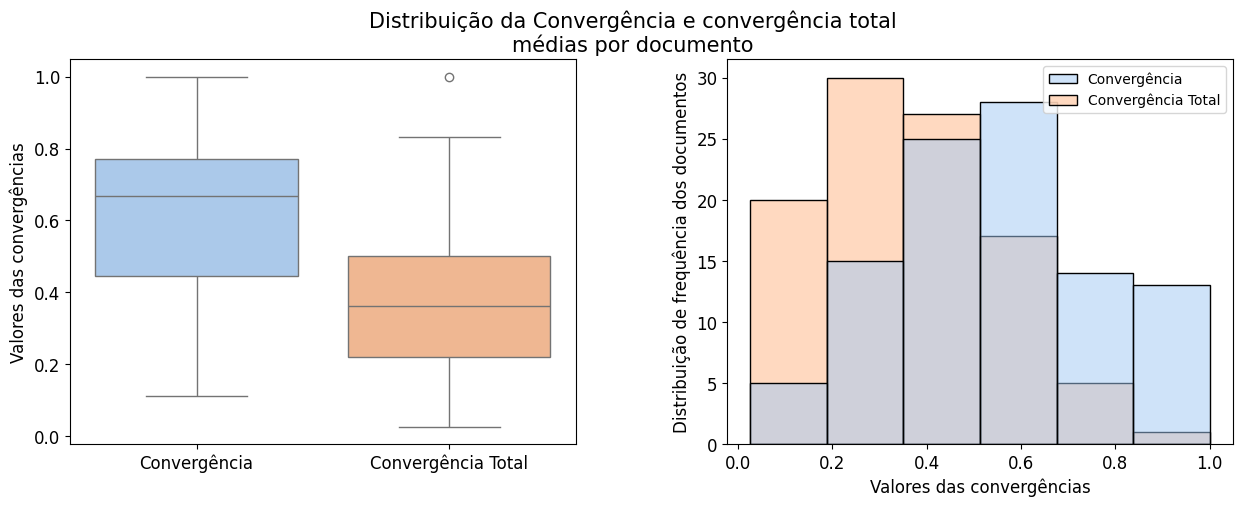

In [ ]:
# fig = plt.figure(figsize=(10, 7))
fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharex=False, sharey=False,)


sns.boxplot(plot_df[["Convergência", "Convergência Total"]],  orient='v' , ax=ax[0], palette="pastel")
sns.histplot(plot_df[["Convergência", "Convergência Total"]], bins=6, ax=ax[1], palette="pastel")

fig.suptitle("Distribuição da Convergência e convergência total\nmédias por documento", fontsize = 15)

ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[1].tick_params(axis='both', which='major', labelsize=12)

# ax[1].set(xlabel='Valores das convergências', ylabel='Distribuição de frequência dos documentos')

ax[0].set_ylabel('Valores das convergências', fontsize = 12)
ax[1].set_xlabel('Valores das convergências', fontsize = 12)
ax[1].set_ylabel('Distribuição de frequência dos documentos', fontsize = 12)

plt.subplots_adjust(wspace=0.3)
plt.plot()

In [ ]:
# Verificando q1, mediana e q3
# Aqui pode se notar que, segundo o critério de convergência aplicado,
# ao menos 50% dos documentos tem convergência de 66,6%.
avg_convergence_per_doc["convergence"].quantile([0.25,0.5,0.75])

0.25    0.444444
0.50    0.666667
0.75    0.770833
Name: convergence, dtype: float64

In [ ]:
avg_convergence_per_doc["total_convergence"].quantile([0.25,0.5,0.75])

0.25    0.218750
0.50    0.361111
0.75    0.500000
Name: total_convergence, dtype: float64

In [ ]:
# Fazendo o cálculo reverso pode ser notado que 71 documentos tem um mínimo de
# 50% de convergência nas sentenças escolhidas

def analize_docs_qtd(df, threshold, ref_col="convergence"):
  return df[df[ref_col] >= threshold].shape[0]

print(f"Qtd de documentos com convergência min. de 0.50      ---> {analize_docs_qtd(avg_convergence_per_doc, 0.50)}.")
print(f"Qtd de documentos com convergência min. de 0.75      ---> {analize_docs_qtd(avg_convergence_per_doc, 0.75)}.")
print(f"Qtd de documentos com convergência min. de 1.00      ---> {analize_docs_qtd(avg_convergence_per_doc, 1.00)}.")
print()
print(f"Qtd de documentos com convergência tot. min. de 0.50 ---> {analize_docs_qtd(avg_convergence_per_doc, 0.50, 'total_convergence')}.")
print(f"Qtd de documentos com convergência tot. min. de 0.75 ---> {analize_docs_qtd(avg_convergence_per_doc, 0.75, 'total_convergence')}.")
print(f"Qtd de documentos com convergência tot. min. de 1.00 ---> {analize_docs_qtd(avg_convergence_per_doc, 1.00, 'total_convergence')}.")

Qtd de documentos com convergência min. de 0.50      ---> 71.
Qtd de documentos com convergência min. de 0.75      ---> 26.
Qtd de documentos com convergência min. de 1.00      ---> 11.

Qtd de documentos com convergência tot. min. de 0.50 ---> 36.
Qtd de documentos com convergência tot. min. de 0.75 ---> 6.
Qtd de documentos com convergência tot. min. de 1.00 ---> 1.


## Análise dos documentos em que houve discordância

In [ ]:
import spacy
import spacy.cli

In [ ]:
spacy.cli.download("pt_core_news_sm")

✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


In [ ]:
nlp = spacy.load('pt_core_news_sm')

In [ ]:
docs_list = pd.read_parquet(save_path + "0_list_b3_pdf_comparison.parquet")[["published_date", "published_title", "file_name"]]
docs_list = docs_list[docs_list["published_date"].dt.year == 2023]
docs_list.head()

,published_date,published_title,file_name
0,2023-11-09,187-2023-PRE-Ofício Circular,2023-11-09|187-2023-PRE-Ofício Circular.pdf
1,2023-11-09,107-2023-VNC-Comunicado Externo,2023-11-09|107-2023-VNC-Comunicado Externo.pdf
2,2023-11-09,058-2023-VPC-Comunicado Externo,2023-11-09|058-2023-VPC-Comunicado Externo.pdf
3,2023-11-09,059-2023-VPC-Comunicado Externo,2023-11-09|059-2023-VPC-Comunicado Externo.pdf
4,2023-11-09,186-2023-PRE-Ofício Circular,2023-11-09|186-2023-PRE-Ofício Circular.pdf


In [ ]:
base_path = "/content/drive/MyDrive/Estudos/Poli/TCC/data/txt_2023"
def fetch_file_content(row):
  file_name = row["txt_file_name"]
  try:
    with open(os.path.join(base_path, file_name), "r") as f:
      content = f.read()
  except Exception as e:
    raise e
  #   content = "NOT_FOUND"

  return content

# docs_df = docs_df.head(10)
docs_list["txt_file_name"] = docs_list["file_name"].str.replace("\.pdf", ".txt", regex=True).str.strip()
docs_list["adobe_extraction"] = docs_list.apply(fetch_file_content, axis=1)

docs_list.head()

In [ ]:
docs_list = pd.read_parquet(save_path + "0_2023_b3_documents_extracted_text.parquet")

In [ ]:
docs_list["split_amount"] = docs_list["adobe_extraction"].str.split().str.len()

In [ ]:
docs_list["tokens_amount"] = docs_list["adobe_extraction"].apply(lambda x: len([token for token in nlp.tokenizer(x)]))

In [ ]:
avg_convergence_per_doc_plt = (
    avg_convergence_per_doc
    .merge(docs_list, on="published_title", how="left")[["convergence", "total_convergence", "tokens_amount"]]
    .rename(columns={"convergence": "Convergência", "total_convergence": "Convergência Total", "tokens_amount": "Quantidade de Tokens"})
    )

[]

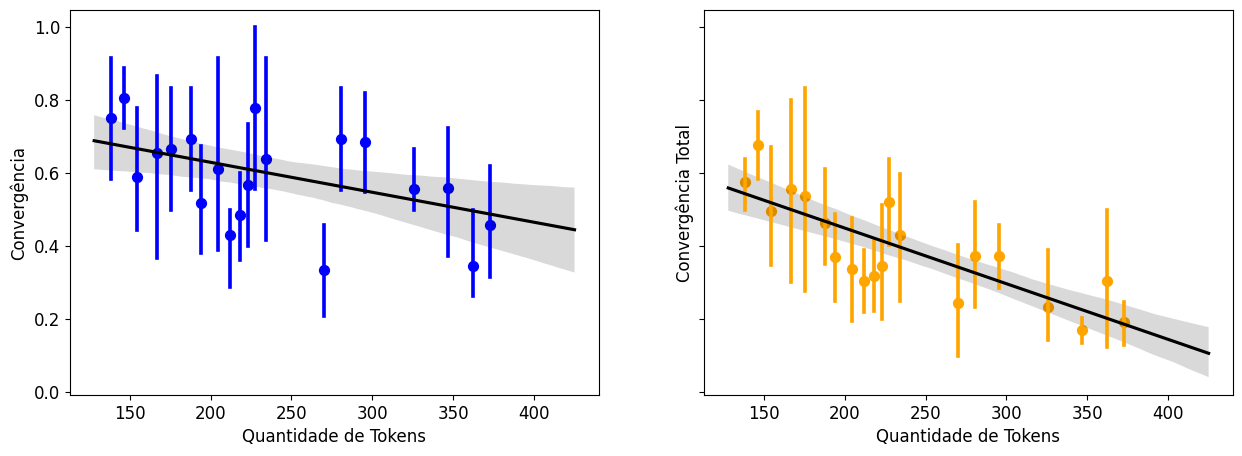

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharex=False, sharey=True,)

sns.regplot(
    y=avg_convergence_per_doc_plt["Convergência Total"],
    x=avg_convergence_per_doc_plt["Quantidade de Tokens"],
    x_bins=20,
    # ci=0.95,
    scatter_kws={"color": "orange"}, line_kws={"color": "black"},
    ax=ax[1]
)

sns.regplot(
    y=avg_convergence_per_doc_plt["Convergência"],
    x=avg_convergence_per_doc_plt["Quantidade de Tokens"],
    x_bins=20,
    # ci=0.95,
    scatter_kws={"color": "blue"}, line_kws={"color": "black"},
    ax=ax[0]
)

ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[1].tick_params(axis='both', which='major', labelsize=12)

ax[0].set_xlabel('Quantidade de Tokens', fontsize = 12)
ax[1].set_xlabel('Quantidade de Tokens', fontsize = 12)

ax[0].set_ylabel('Convergência', fontsize = 12)
ax[1].set_ylabel('Convergência Total', fontsize = 12)

plt.plot()

### Análise por Coleman-Liau

In [ ]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

# CLI = 0.0588 * L - 0.296 * S - 15.8
# L = (Letters ÷ Words) × 100
# S = (Sentences ÷ Words) × 100

docs_list["doc_sentences"] = docs_list["adobe_extraction"].apply(lambda row: sent_tokenize(row))
docs_list["sentences_qtd"] = docs_list["doc_sentences"].apply(len)
docs_list["words_qtd"] = docs_list["adobe_extraction"].apply(lambda row: len(tokenizer.tokenize(row)))
docs_list["chars_qtd"] = docs_list["adobe_extraction"].apply(lambda txt: len([word for word in txt if word.isalnum()]))

docs_list["cl_l"] = (docs_list["chars_qtd"] / docs_list["words_qtd"]) * 100
docs_list["cl_s"] = (docs_list["sentences_qtd"] / docs_list["words_qtd"]) * 100

docs_list["coleman_liau"] = 0.0588 * docs_list["cl_l"] - 0.296 * docs_list["cl_s"] - 15.8
docs_list.head()

,published_date,published_title,file_name,txt_file_name,adobe_extraction,tokens_amount,doc_sentences,sentences_qtd,words_qtd,chars_qtd,cl_l,cl_s,coleman_liau
0,2023-11-09,187-2023-PRE-Ofício Circular,2023-11-09|187-2023-PRE-Ofício Circular.pdf,2023-11-09|187-2023-PRE-Ofício Circular.txt,"Informamos que, a partir de 13/11/2023, inclus...",144,"[Informamos que, a partir de 13/11/2023, inclu...",7,129,660,511.627907,5.426357,12.677519
1,2023-11-09,107-2023-VNC-Comunicado Externo,2023-11-09|107-2023-VNC-Comunicado Externo.pdf,2023-11-09|107-2023-VNC-Comunicado Externo.txt,"A B3 informa que, conforme Comunicado Externo ...",278,"[A B3 informa que, conforme Comunicado Externo...",13,249,1334,535.742972,5.220884,14.156305
2,2023-11-09,058-2023-VPC-Comunicado Externo,2023-11-09|058-2023-VPC-Comunicado Externo.pdf,2023-11-09|058-2023-VPC-Comunicado Externo.txt,"Informamos que, em 27/10/2023, a Receita Feder...",566,"[Informamos que, em 27/10/2023, a Receita Fede...",24,515,2688,521.941748,4.660194,13.510757
3,2023-11-09,059-2023-VPC-Comunicado Externo,2023-11-09|059-2023-VPC-Comunicado Externo.pdf,2023-11-09|059-2023-VPC-Comunicado Externo.txt,"A B3 informa que, no dia 13/11/2023, atualizar...",167,"[A B3 informa que, no dia 13/11/2023, atualiza...",5,151,821,543.708609,3.311258,15.189934
4,2023-11-09,186-2023-PRE-Ofício Circular,2023-11-09|186-2023-PRE-Ofício Circular.pdf,2023-11-09|186-2023-PRE-Ofício Circular.txt,"Informamos que, a partir de 27/11/2023, serão ...",393,"[Informamos que, a partir de 27/11/2023, serão...",19,359,1910,532.033426,5.292479,13.916992


In [ ]:
avg_convergence_with_cl = avg_convergence_per_doc.merge(docs_list, on="published_title", how="left")

In [ ]:
avg_convergence_with_cl.head()

,published_title,convergence,total_convergence,len_passage_content_sents,published_date,file_name,txt_file_name,adobe_extraction,tokens_amount,doc_sentences,sentences_qtd,words_qtd,chars_qtd,cl_l,cl_s,coleman_liau
0,059-2023-VNC-Comunicado Externo,0.111111,0.111111,8,2023-06-22,2023-06-22|059-2023-VNC-Comunicado Externo.pdf,2023-06-22|059-2023-VNC-Comunicado Externo.txt,A B3 informa que foram incluídas no calendário...,169,[A B3 informa que foram incluídas no calendári...,8,162,773,477.160494,4.938272,10.795309
1,146-2023-PRE-Ofício Circular,0.142857,0.142857,21,2023-08-24,2023-08-24|146-2023-PRE-Ofício Circular.pdf,2023-08-24|146-2023-PRE-Ofício Circular.txt,"Informamos que, em 28/08/2023, entrará em vigo...",368,"[Informamos que, em 28/08/2023, entrará em vig...",21,318,1622,510.062893,6.603774,12.236981
2,062-2023-VNC-Comunicado Externo,0.166667,0.083333,11,2023-06-29,2023-06-29|062-2023-VNC-Comunicado Externo.pdf,2023-06-29|062-2023-VNC-Comunicado Externo.txt,"Informamos que, a partir de 15/07/2023, o gate...",270,"[Informamos que, a partir de 15/07/2023, o gat...",11,243,1349,555.144033,4.526749,15.502551
3,102-2023-PRE-Ofício Circular,0.166667,0.025641,26,2023-06-22,2023-06-22|102-2023-PRE-Ofício Circular.pdf,2023-06-22|102-2023-PRE-Ofício Circular.txt,"A B3 informa que divulgará, até 30/06/2023, a ...",375,"[A B3 informa que divulgará, até 30/06/2023, a...",26,324,1781,549.691358,8.024691,14.146543
4,110-2023-PRE-Ofício Circular,0.187037,0.187037,18,2023-06-27,2023-06-27|110-2023-PRE-Ofício Circular.pdf,2023-06-27|110-2023-PRE-Ofício Circular.txt,A B3 informa que concederá aos participantes d...,348,[A B3 informa que concederá aos participantes ...,21,297,1574,529.966330,7.070707,13.269091


In [ ]:
avg_convergence_with_cl_plot = (
    avg_convergence_with_cl
    .rename(columns={"convergence": "Convergência", "total_convergence": "Convergência Total", "tokens_amount": "Quantidade de Tokens", "coleman_liau": "Índice de Coleman-Liau"})
    )

[]

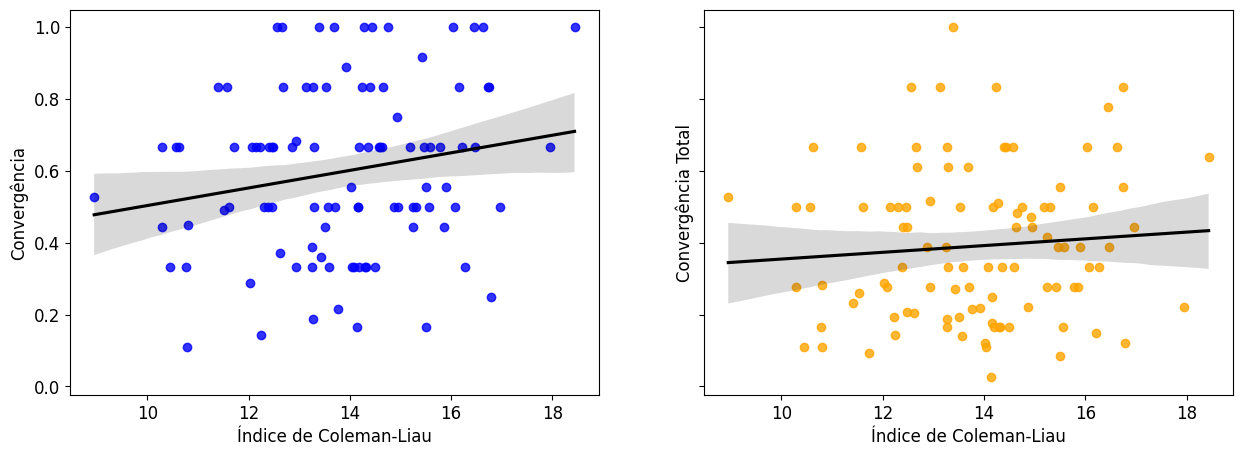

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharex=False, sharey=True,)

sns.regplot(
    y=avg_convergence_with_cl_plot["Convergência Total"],
    x=avg_convergence_with_cl_plot["Índice de Coleman-Liau"],
    # x_bins=20,
    # ci=0.95,
    scatter_kws={"color": "orange"}, line_kws={"color": "black"},
    ax=ax[1]
)

sns.regplot(
    y=avg_convergence_with_cl_plot["Convergência"],
    x=avg_convergence_with_cl_plot["Índice de Coleman-Liau"],
    # x_bins=20,
    # ci=0.95,
    scatter_kws={"color": "blue"}, line_kws={"color": "black"},
    ax=ax[0]
)


ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[1].tick_params(axis='both', which='major', labelsize=12)


ax[0].set_xlabel('Índice de Coleman-Liau', fontsize = 12)
ax[1].set_xlabel('Índice de Coleman-Liau', fontsize = 12)

ax[0].set_ylabel('Convergência', fontsize = 12)
ax[1].set_ylabel('Convergência Total', fontsize = 12)

plt.plot()

In [ ]:
avg_convergence_with_cl[["convergence", "total_convergence", "coleman_liau"]].corr()

,convergence,total_convergence,coleman_liau
convergence,1.000000,0.730059,0.194570
total_convergence,0.730059,1.000000,0.083769
coleman_liau,0.194570,0.083769,1.000000


In [ ]:
avg_convergence_with_cl[avg_convergence_with_cl["convergence"] >= 0.50][["convergence", "total_convergence", "coleman_liau"]].corr()

,convergence,total_convergence,coleman_liau
convergence,1.000000,0.582113,0.146761
total_convergence,0.582113,1.000000,-0.018490
coleman_liau,0.146761,-0.018490,1.000000


In [ ]:
avg_convergence_with_cl[avg_convergence_with_cl["convergence"] < 0.50][["convergence", "total_convergence", "coleman_liau"]].corr()

,convergence,total_convergence,coleman_liau
convergence,1.000000,0.599107,-0.086647
total_convergence,0.599107,1.000000,0.040648
coleman_liau,-0.086647,0.040648,1.000000


## Recompondo o dataset com base na convergência definida

In [ ]:
from itertools import repeat
from random import uniform, randint, seed

conv_threshold = 0.50
seed(42)

def _draw_reference_sumary(df):

  df_rows_len = df.shape[0]
  random_idxs = [1 if uniform(0, 1) <= 0.50 else 2 for i in repeat(None, df_rows_len)]
  df = df.assign(chosen_summary_idx=random_idxs)

  return df


def filter_dataframe_based_on_avg_conv(df, avg_conv_df, conv_threshold, conv_col="convergence"):
  filtered_avg_conv_docs = avg_conv_df[avg_conv_df[conv_col] >= conv_threshold]
  drawed_summaries_df = _draw_reference_sumary(filtered_avg_conv_docs)

  return df.merge(drawed_summaries_df, on="published_title", how="inner")

def recover_choosen_extracted_summary(df):

  df["target_summary"] = df.apply(lambda row: row['ext_1_summary'] if row["chosen_summary_idx"] == 1 else row['ext_2_summary'], axis=1)

  return df

def select_columns_of_interest(df):
  cols = [
      "published_title",
      "text_passage_idx",
      "target_summary",
  ]
  return df[cols]

def compose_summary_per_document(df):
  return (
      df
      .groupby(['published_title'])['target_summary']
      .apply(' '.join)
      .reset_index()
  )

In [ ]:
filtered_df = filter_dataframe_based_on_avg_conv(merged_df, avg_convergence_per_doc, conv_threshold)

In [ ]:
chosen_summaries_df = recover_choosen_extracted_summary(filtered_df)

In [ ]:
df_to_process = select_columns_of_interest(chosen_summaries_df)

In [ ]:
processed_df = compose_summary_per_document(df_to_process)

## Compondo o dataset final com os textos integrais e os sumários de referência

In [ ]:
def fetch_file_content(row):
  file_name = row["txt_file_name"]
  try:
    with open(os.path.join(pdfs_path, file_name), "r") as f:
      content = f.read()
  except Exception as e:
    raise e

  return content

In [ ]:
base_path = "/content/drive/MyDrive/Estudos/Poli/TCC/"
save_path = base_path + "notebooks/"
pdfs_path = base_path + "data/txt_2023/"

docs_cols = [
    "published_date",
    "published_title",
    "file_name",
]
docs_df = pd.read_parquet(f"{save_path}0_list_b3_pdf_comparison.parquet", engine="pyarrow")
docs_df = docs_df[docs_cols]

# Filtrando apenas entradas do ano de 2023
docs_df = docs_df[docs_df["published_date"].dt.year == 2023]

# Retirando o conteúdo dos PDFs
docs_df["txt_file_name"] = docs_df["file_name"].str.replace("\.pdf", ".txt", regex=True).str.strip()
docs_df["adobe_extraction"] = docs_df.apply(fetch_file_content, axis=1)

In [ ]:
source_docs_df = docs_df[["published_title", "adobe_extraction"]].copy()
source_docs_df.rename(columns={"adobe_extraction": "source_text"}, inplace=True)

In [ ]:
target_summaries = source_docs_df.merge(processed_df, on="published_title", how="inner")

In [ ]:
# Confirmando qtde de dados
target_summaries.shape

(71, 3)

In [ ]:
target_summaries.to_csv(save_path + "summaries_dataset.csv")